In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Task 1

In [3]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [6]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [7]:
help(tf.function)

Help on function function in module tensorflow.python.eager.polymorphic_function.polymorphic_function:

function(func=None, input_signature=None, autograph=True, jit_compile=None, reduce_retracing=False, experimental_implements=None, experimental_autograph_options=None, experimental_attributes=None, experimental_relax_shapes=None, experimental_compile=None, experimental_follow_type_hints=None) -> tensorflow.python.types.core.PolymorphicFunction
    Compiles a function into a callable TensorFlow graph. (deprecated arguments) (deprecated arguments) (deprecated arguments)
    
    Deprecated: SOME ARGUMENTS ARE DEPRECATED: `(experimental_compile)`. They will be removed in a future version.
    Instructions for updating:
    experimental_compile is deprecated, use jit_compile instead
    
    Deprecated: SOME ARGUMENTS ARE DEPRECATED: `(experimental_relax_shapes)`. They will be removed in a future version.
    Instructions for updating:
    experimental_relax_shapes is deprecated, use redu

In [8]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    pass
    # loss_term = bernoulli loss between true x and predicted x_decoded

    # KL_term = KL divergence between normal with params z_mean, z_log_var and standard multivariate normal

    # return tf.reduce_mean(loss_term - KL_term)

In [10]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        return # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [13]:
original_dim

784

In [15]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │      2,570 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │      2,570 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 10)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 271,892 (1.04 MB)

 Trainable params: 271,892 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,096 (1.03 MB)

 Trainable params: 270,096 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 223.5700 - total_loss: 180.7780
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 138.4613 - total_loss: 134.5527
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 125.8314 - total_loss: 124.5834
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 120.1904 - total_loss: 119.5774
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 116.6300 - total_loss: 116.2326
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 114.2205 - total_loss: 113.7989
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 111.8820 - total_loss: 112.0299
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 110.6831 - total_loss: 110.6263
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 109.6124 - total_loss: 109.5823
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 108.6639 - total_loss: 108.6548


## f)

In [24]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [30]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
# decoder predictions - we take a vector from the latent space and transform it to be again a picture
test_pred = vae.decoder.predict(z_test_pred[2])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [32]:
test_pred.shape

(10000, 784)

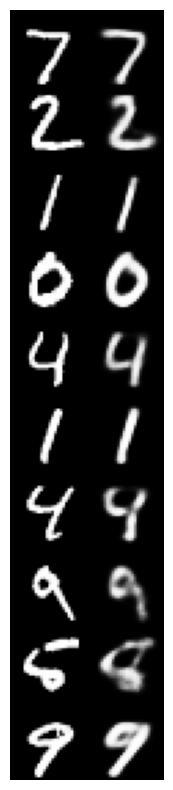

In [34]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [ ]:
# use z_test_pred

In [36]:
tsne = TSNE(n_components=2)

In [38]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

In [45]:
z_test_pred_tsne.shape, y_test.shape

((10000, 2), (10000,))

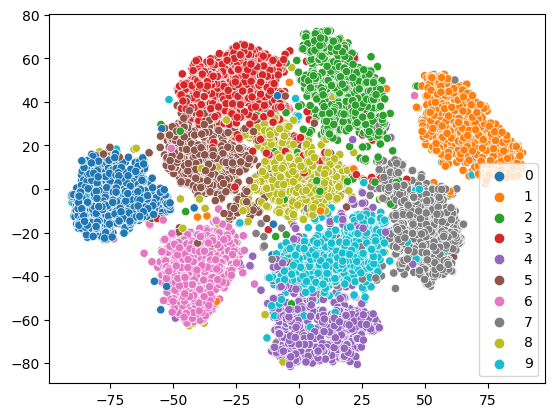

In [41]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [49]:
p_z = np.random.multivariate_normal([0]*10,np.diag(np.ones(10)),10)

p_z_decoded = vae.decoder.predict(p_z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [51]:
p_z.shape, p_z_decoded.shape

((10, 10), (10, 784))

In [58]:
figure.shape, np.sqrt(p_z_decoded.shape[1]).astype(int)

((280, 56), 28)

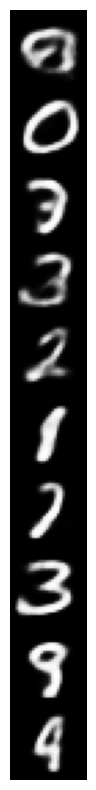

In [61]:
n = p_z_decoded.shape[0]  # figure with 10 x 1 digits
digit_size = np.sqrt(p_z_decoded.shape[1]).astype(int)
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
decoded = p_z_decoded

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


# Task 2

In [13]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim+1,)) #original input with the class information
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 785)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    201,216 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │      2,570 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │      2,570 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 10)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,148 (1.04 MB)

 Trainable params: 272,148 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
latent_inputs = keras.Input(shape=(latent_dim+1,)) # additional dimension according to the y
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,352 (1.03 MB)

 Trainable params: 270,352 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        """
        now data have the c vector as last columns
        """
        c = tf.cast(data[:,-1], dtype=tf.float32)
        c = tf.reshape(c, (-1,1))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(tf.concat([z,c], 1))

            total_loss = -elbo_vae(data[:,:-1], reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [28]:
cvae = cVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(np.c_[x_train, y_train], epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 219.5110 - total_loss: 176.7996
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 138.0470 - total_loss: 134.2235
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 125.6446 - total_loss: 123.9923
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 119.6492 - total_loss: 118.9310
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 115.9592 - total_loss: 115.7229
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 113.7221 - total_loss: 113.3574
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 111.6426 - total_loss: 111.7684
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 110.3647 - total_loss: 110.3857
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 109.2146 - total_loss: 109.4159
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 108.1540 - total_loss: 108.4509


## f)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


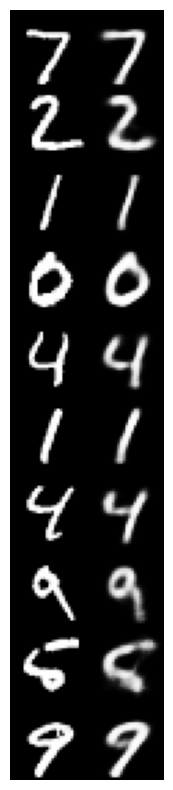

In [37]:
z_test_pred = cvae.encoder.predict(np.c_[x_test,y_test])
test_pred = cvae.decoder.predict(np.c_[z_test_pred[2],y_test])


n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [38]:
tsne = TSNE(n_components=2)

In [39]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

In [40]:
z_test_pred_tsne.shape, y_test.shape

((10000, 2), (10000,))

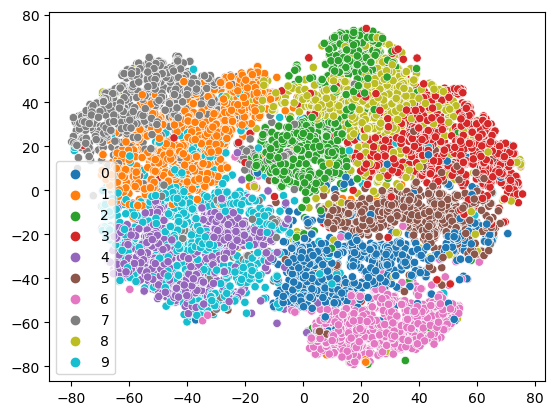

In [41]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [47]:
p_z = np.random.multivariate_normal([0]*10,np.diag(np.ones(10)),10)
y_sample = np.arange(0,10)

p_z_decoded = cvae.decoder.predict(np.c_[p_z,y_sample])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [48]:
p_z.shape, p_z_decoded.shape

((10, 10), (10, 784))

In [49]:
figure.shape, np.sqrt(p_z_decoded.shape[1]).astype(int)

((280, 28), 28)

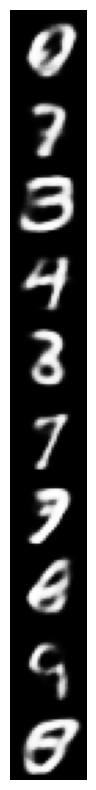

In [50]:
n = p_z_decoded.shape[0]  # figure with 10 x 1 digits
digit_size = np.sqrt(p_z_decoded.shape[1]).astype(int)
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
decoded = p_z_decoded

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()
